In [1]:
# Unpack tesselate
!tar -zxf /home/jupyter/examples/tesselate/src/tesselate-0.1.1.tar.gz -C /home/jupyter/examples/tesselate/src/
# Add package to python path.
import sys
sys.path.append('/home/jupyter/examples/tesselate/src/tesselate-0.1.1')
# Import tesselate.
import tesselate as ts
# Authenticate by logging in or setting token manually.
# ts.client.authenticate('daniel', '***')
ts.client.set_token('6f3ada23575910a7db8a4cd1cec5075ebb65c79d')

### Search for a region (aggregationlayer)

In [2]:
import json
# Search for regions
regions = ts.region(search='Ethiopia')
print(json.dumps(regions, indent = 2))
# Keep ethiopia
ethiopia = regions[0]

[
  {
    "min_zoom_level": 0,
    "extent": [
      35.84607600776938,
      11.392510283713559,
      35.87258211283826,
      11.41945303141402
    ],
    "max_zoom_level": 18,
    "nr_of_areas": 1,
    "name": "Ethiopia Land",
    "aggregationareas": [
      1420
    ],
    "id": 74,
    "description": ""
  }
]


### Search for composite

In [3]:
composites = ts.composite(min_date_0='2017-04-01', min_date_1='2018-03-31', interval='Monthly')
print('Found {} composites.'.format(len(composites)))
print([dat['name'] for dat in composites])

Found 12 composites.
['April 2017', 'May 2017', 'June 2017', 'July 2017', 'August 2017', 'September 2017', 'October 2017', 'November 2017', 'December 2017', 'January 2018', 'February 2018', 'March 2018']


### Search for a formula

In [4]:
# Get NDVI formulas.
formulas = ts.formula(search='NDVI')
print(json.dumps(formulas, indent = 2))
# Keep regular NDVI
ndvi = formulas[0]

# Get RGB formula
rgb = ts.formula(search='RGB')[0]

[
  {
    "max_val": 1.0,
    "min_val": -1.0,
    "color_palette": "RdYlGn",
    "acronym": "NDVI",
    "breaks": 0,
    "name": "Natural Difference Vegetation Index",
    "id": 1,
    "description": "",
    "formula": "(B8 - B4) / (B8 + B4)"
  },
  {
    "max_val": 0.75,
    "min_val": 0.25,
    "color_palette": "Greens",
    "acronym": "NDVI+",
    "breaks": 1,
    "name": "Positive Clear NDVI",
    "id": 3,
    "description": "Vegetation as measured by positive NDVI scores.",
    "formula": "((B8 - B4) / (B8 + B4)) * (B3 < 1500)"
  }
]


### Export data into files on disk

In [5]:
import os
# Set data directory.
base_path = '/home/jupyter/examples/tesselate/data'
composite = composites[2]
# Export NDVI
ts.export(ethiopia, composite, ndvi, os.path.join(base_path, 'ndvi_{}_ethiopia.tif'.format('_'.join(composite['name'].split(' ')))))
# Export RGB
ts.export(ethiopia, composite, rgb, os.path.join(base_path, 'rgb_{}_ethiopia.tif'.format('_'.join(composite['name'].split(' ')))))

INFO: Processing "Natural Difference Vegetation Index" over "Ethiopia Land" for "June 2017"
INFO: Processing "Visual Bands" over "Ethiopia Land" for "June 2017"


<module 'matplotlib.pyplot' from '/home/jupyter/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

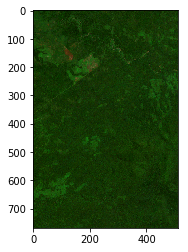

In [10]:
# Plot exported data.
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread(os.path.join(base_path, 'rgb_{}_ethiopia.tif'.format('_'.join(composite['name'].split(' ')))))
plt.imshow(img)
plt

### Compute aggregation values for

In [11]:
aggregates = []
for area_id in ethiopia['aggregationareas']:
    area = ts.area(area_id)
    aggregates.append(ts.aggregate(area, composite, ndvi))
print(json.dumps(aggregates, indent = 2))

[
  {
    "pcount": 57961.0,
    "value": {
      "(0.8282143229982253, 0.8609242440059853)": 7774.0,
      "(0.6973746389671852, 0.7300845599749453)": 16.0,
      "(0.6646647179594252, 0.6973746389671852)": 6.0,
      "(0.6319547969516651, 0.6646647179594252)": 4.0,
      "(0.5992448759439051, 0.6319547969516651)": 3.0,
      "(0.8936341650137454, 0.9263440860215054)": 4720.0,
      "(0.7627944809827052, 0.7955044019904652)": 129.0,
      "(0.8609242440059853, 0.8936341650137454)": 44360.0,
      "(0.7300845599749453, 0.7627944809827052)": 41.0,
      "(0.7955044019904652, 0.8282143229982253)": 908.0
    },
    "avg": 0.874627487126183,
    "psum": 50694.2837813207,
    "rasterlayers": [
      5063,
      5059
    ],
    "layer_names": {
      "B8": "5063",
      "B4": "5059"
    },
    "id": 1492,
    "formula": "(B8-B4)/(B8+B4)",
    "min": 0.599244875943905,
    "zoom": 14,
    "std": 0.0172850774655871,
    "max": 0.926344086021505,
    "psumsq": 44355.9312695095,
    "name": "Ana

### Compute regional aggregates

In [12]:
# This is a dummy example with only one aggregation area.
# However, this function takes a list of value count results
# and returns the regional statistics.
regional_aggregate = ts.regional_aggregate(aggregates)

print(json.dumps(regional_aggregate, indent = 2))

{
  "min": 0.599244875943905,
  "std": 0.017285077465624056,
  "mean": 0.8746274871261831,
  "max": 0.926344086021505
}


### Compute value counts by z-score breaks

In [13]:
# Get grouping parameter.
z_scores = ts.z_scores_grouping(regional_aggregate['mean'], regional_aggregate['std'])
print(json.dumps(z_scores, indent = 2))

# Re-compute aggregates using the z-score breaks.
z_aggregates = []
for area_id in ethiopia['aggregationareas']:
    area = ts.area(area_id)
    z_aggregates.append(ts.aggregate(area, composite, ndvi, z_scores))

print(json.dumps(z_aggregates, indent = 2))

[
  {
    "expression": "x<0.840057332194935",
    "name": "Very low",
    "color": "#d7191c"
  },
  {
    "expression": "(x>=0.840057332194935) & (x<=0.8573424096605591)",
    "name": "Low",
    "color": "#fdae61"
  },
  {
    "expression": "(x>0.8573424096605591) & (x<0.8919125645918071)",
    "name": "Average",
    "color": "#ffffbf"
  },
  {
    "expression": "(x>=0.8919125645918071) & (x<=0.9091976420574313)",
    "name": "High",
    "color": "#a6d96a"
  },
  {
    "expression": "x>0.9091976420574313",
    "name": "Very High",
    "color": "#1a9641"
  }
]
[
  {
    "pcount": 57961.0,
    "value": {
      "x<0.840057332194935": 2187.0,
      "(x>0.8573424096605591) & (x<0.8919125645918071)": 44901.0,
      "(x>=0.840057332194935) & (x<=0.8573424096605591)": 4725.0,
      "(x>=0.8919125645918071) & (x<=0.9091976420574313)": 5966.0,
      "x>0.9091976420574313": 182.0
    },
    "avg": 0.874627487126183,
    "psum": 50694.2837813207,
    "rasterlayers": [
      5063,
      5059
    ]